In [117]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from numpy.linalg import inv
from sklearn.covariance import LedoitWolf
import cvxpy as cp
from numpy.linalg import inv, pinv
import matplotlib.pyplot as plt

In [118]:
def calculate_historical_stats(returns, use_shrinkage, method="sample", decay=0.94):
    """
    Computes the mean returns and covariance matrix for a given returns matrix.

    Parameters:
      returns: np.array of shape (T, N)
      use_shrinkage: if True and method=="sample", applies Ledoit–Wolf shrinkage.
      method: "sample" for simple averages, or "ewma" for Exponentially Weighted Moving Average.
      decay: decay factor for EWMA.

    Returns:
      mean_returns: np.array of shape (N,)
      cov_matrix: np.array of shape (N, N)
    """
    T, N = returns.shape
    if method == "sample":
        mean_returns = np.mean(returns, axis=0)
        if use_shrinkage:
            lw = LedoitWolf()
            cov_matrix = lw.fit(returns).covariance_
        else:
            cov_matrix = np.cov(returns, rowvar=False)
    elif method == "ewma":
        # Vectorized EWMA weights computation
        weights = decay ** (np.arange(T - 1, -1, -1))
        weights /= np.sum(weights)
        mean_returns = np.average(returns, axis=0, weights=weights)
        diff = returns - mean_returns
        cov_matrix = np.zeros((N, N))
        for t in range(T):
            cov_matrix += weights[t] * np.outer(diff[t], diff[t])
    else:
        raise ValueError("Method must be 'sample' or 'ewma'.")
    return mean_returns, cov_matrix


In [119]:
def optimize_portfolio(mean_returns, cov_matrix, risk_aversion):
    """
    Optimizes portfolio weights by minimizing:
         risk_aversion * (w^T Σ w) - (w^T mean_returns)
    Subject to: sum(w) = 1 and 0 <= w_i <= 1.
    """
    n = len(mean_returns)
    w = cp.Variable(n)
    # Ensure covariance matrix is symmetric (for numerical stability)
    cov_matrix = (cov_matrix + cov_matrix.T) / 2 + 1e-6 * np.eye(n)
    cov_matrix = nearest_psd(cov_matrix)
    # Objective function
    objective = cp.Minimize(risk_aversion * cp.quad_form(w, cov_matrix,assume_PSD=True) - mean_returns @ w)
    # Constraints
    constraints = [cp.sum(w) == 1, w >= 0, w<=0.2]

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)

    if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        return w.value
    else:
        raise ValueError("Portfolio optimization did not converge.")

In [120]:
def implied_excess_returns(lambda_val, cov_matrix, market_weights, rf):
    """
    Computes CAPM-based implied excess returns:
         π* = λ * (Σ * market_weights), then adds rf: π = π* + rf.
    """
    pi_star = lambda_val * (cov_matrix @ market_weights)
    return pi_star + rf

In [121]:
def black_litterman(tau, cov_matrix, implied_returns, P, Omega, Q):
    """
    Applies the Black–Litterman model to adjust returns and covariance.
    """
    # Ensure Omega is invertible using pseudo-inverse
    Omega_inv = pinv(Omega)  # Handles singular matrices better

    # Compute tau-scaled covariance inverse
    tauSigma_inv = inv(tau * cov_matrix)
    reg = 1e-8  # You can adjust this small constant as needed
    #tauSigma_inv = inv(tau * cov_matrix + reg * np.eye(cov_matrix.shape[0]))


    # Compute middle term (P.T * Omega_inv * P + tauSigma_inv)
    middle_matrix = tauSigma_inv + P.T @ Omega_inv @ P

    # Solve for inverse more stably
    middle_inv = np.linalg.solve(middle_matrix, np.eye(middle_matrix.shape[0]))

    # Compute adjusted expected returns
    adjusted_term = tauSigma_inv @ implied_returns + P.T @ Omega_inv @ Q
    EBL = middle_inv @ adjusted_term

    # Compute Black-Litterman covariance update
    Sigma_BL = cov_matrix - (middle_inv @ P.T @ Omega_inv @ P @ cov_matrix)

    return EBL, Sigma_BL

In [122]:
def compute_performance_metrics(portfolio_returns, rf=0.04):
    """
    Computes performance metrics from monthly portfolio returns.
    """
    rf_monthly = rf / 12.0
    excess_returns = portfolio_returns - rf_monthly
    std_portfolio_returns = np.std(portfolio_returns)
    avg_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns)
    sharpe_ratio = (avg_excess_return / std_portfolio_returns * np.sqrt(12)
                    if std_excess_return != 0 else np.nan)
    annual_volatility = np.std(portfolio_returns) * np.sqrt(12)
    cumulative_return = np.prod(1 + portfolio_returns) - 1

    return {
        "avg_monthly_return": np.mean(portfolio_returns),
        "annual_volatility": annual_volatility,
        "sharpe_ratio": sharpe_ratio,
        "cumulative_return": cumulative_return
    }

In [123]:
def rolling_portfolio_optimization(monthly_returns, monthly_market_caps, dates, rfr, sp500_returns,window, use_shrinkage,
                                   stat_method="sample", decay=0.94):
    """
    Implements a rolling monthly rebalancing strategy.
    For each month, uses the previous 'window' months to:
      1. Estimate historical statistics.
      2. Build and approximate the efficient frontier.
      3. Compute the market point and risk-aversion parameter.
      4. Calculate CAPM-implied returns (using market cap weights).
      5. Define expert views (based on normalized differences).
      6. Apply the Black–Litterman model.
      7. Optimize portfolio weights with transaction cost penalty.

    Additionally, for each rebalancing period, saves:
      - The monthly profit/loss (portfolio return)
      - The CAPM-implied returns (prior)
      - The expert views (P and Q)
      - The posterior (BL) optimized weights

    Returns:
      portfolio_returns: np.array of monthly portfolio returns.
      weights_history: np.array of posterior weights.
      results_df: DataFrame containing monthly Date, ProfitLoss, PriorReturns, ExpertViews_P, ExpertViews_Q, and PosteriorWeights.
    """
    T, N = monthly_returns.shape # rows, columns
    window = 6
    tau = 1 / window  # parameter from paper
    portfolio_returns = []
    weights_history = []
    results = []  # to store detailed info per period
    prev_weights = None


    # Rebalance from month 'window' to the last month.
    for i in range(window, T):
        #print(i)
        train_data = monthly_returns[i-window:i, :]  # estimation window
        test_returns = monthly_returns[i, :]          # next month returns

        # 1. Historical stats
        mean_train, cov_train = calculate_historical_stats(train_data, use_shrinkage, method=stat_method, decay=decay)
        lambda_val = estimate_risk_aversion_sp(sp500_returns[i-window:i], rfr[i])

        # 4. CAPM-implied returns using market cap weights computed over the window.
        avg_market_caps = np.mean(monthly_market_caps[i-window:i, :], axis=0)
        market_weights = avg_market_caps / np.sum(avg_market_caps)
        implied_returns = implied_excess_returns(lambda_val, cov_train, market_weights, rfr[i])

        # Define expert views for ALL assets
        asset_variances = np.diag(cov_train)
        diff = (implied_returns - mean_train)/2  # Relative expected outperformance

        P = np.eye(N)  # Each asset gets its own row in P
        Q = diff  # Each asset's expected return adjustment

        #  Uncertainty in views: diagonal of (P Σ P^T)
        Omega = np.diag(np.diag(P @ cov_train @ P.T))*10

        # 6. Black–Litterman adjustment
        try:
            EBL, Sigma_BL = black_litterman(tau, cov_train, implied_returns, P, Omega, Q)
            weights_BL = optimize_portfolio(EBL, Sigma_BL, lambda_val)
        except Exception as e:
            print(f"Error in BL model at index {i}: {e}")
            weights_BL = prev_weights


        weights_history.append(weights_BL)
        prev_weights = weights_BL.copy()  # update for next period

        # Calculate portfolio profit/loss for test month.
        port_return = weights_BL @ test_returns
        portfolio_returns.append(port_return)

        # Record detailed info for this period.
        results.append({
            "Date": dates[i],
            "Portfolio Return": port_return,
            "PriorReturns": list(implied_returns),
            "ExpertViews_Q": list(Q),
            "PosteriorWeights": list(weights_BL)
        })

    results_df = pd.DataFrame(results)
    return np.array(portfolio_returns), np.array(weights_history), results_df


In [124]:
def load_sp500_returns(csv_path):
    """
    Loads S&P 500 returns from a CSV file.
    Assumes columns: 'Date', 'Monthly Return'.
    """
    df = pd.read_csv(csv_path, parse_dates=['Date'])

    # Ensure returns are numeric
    df['Monthly Return'] = pd.to_numeric(df['Monthly Return'], errors='coerce')

    # Drop NaN values (first row might be NaN if missing)
    df = df.dropna()

    return df

In [125]:
def estimate_risk_aversion_sp(sp500_returns, rf):
    """
    Estimates the risk-aversion parameter (lambda) using historical market return and volatility.

    sp500_returns: numpy array of monthly returns
    rf: monthly risk-free rate
    """
    E_M = np.mean(sp500_returns)  # Expected market return
    sigma_M2 = np.var(sp500_returns)  # Market variance
    #print(E_M)
    #print(sigma_M2)

    if sigma_M2 == 0:  # Avoid division by zero
        print("Warning: Market variance is zero. Using default λ = 10.")
        return 10  # Default high risk aversion if market variance is too small

    lambda_val = (E_M - rf) / sigma_M2

    if lambda_val > 7 or lambda_val < 1 or np.any(np.isnan(lambda_val)) :
      lambda_val = 4
    return lambda_val


In [126]:
def nearest_psd(matrix):
    """ Ensure the covariance matrix is positive semi-definite """
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals[eigvals < 0] = 0  # Set negative eigenvalues to zero
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

In [127]:
# Load CSV files with dates as index.
prices_df = pd.read_excel("/content/Price_data.xlsx", index_col=0, parse_dates=True)
market_caps_df = pd.read_excel("/content/mkt_cap.xlsx", index_col=0, parse_dates=True)
rfr_df = pd.read_excel("/content/RFR.xlsx", index_col=0, parse_dates=True)
sp500_returns = pd.read_csv("/content/sp500_monthly_returns.csv", index_col=0, parse_dates=True)
# Compute monthly returns from stock prices.
monthly_returns_df = prices_df.pct_change().dropna()

# Align market cap data with monthly returns.
monthly_market_caps_df = market_caps_df.loc[monthly_returns_df.index]
rfr_df = rfr_df.loc[monthly_returns_df.index]
# Convert DataFrames to NumPy arrays.
monthly_returns = monthly_returns_df.values
monthly_market_caps = monthly_market_caps_df.values
rfr = rfr_df['PX_LAST'].to_numpy()/1200
dates = monthly_returns_df.index

In [128]:
# Set parameters.
window = 6      # historical window (months)
stat_method = "sample"
decay = 0.94

# Run rolling portfolio optimization.
portfolio_returns, weights_history, results_df = rolling_portfolio_optimization(
    monthly_returns, monthly_market_caps, dates, rfr, sp500_returns.values,window=window, use_shrinkage=False,
    stat_method=stat_method, decay=decay)

# Compute performance metrics.
perf_metrics = compute_performance_metrics(portfolio_returns, rfr[window:])
print("Performance Metrics:")
for key, value in perf_metrics.items():
    print(f"  {key}: {value:.4f}")



Error in BL model at index 137: Singular matrix
Error in BL model at index 235: Singular matrix
Performance Metrics:
  avg_monthly_return: 0.0143
  annual_volatility: 0.2030
  sharpe_ratio: 0.8332
  cumulative_return: 17.1015


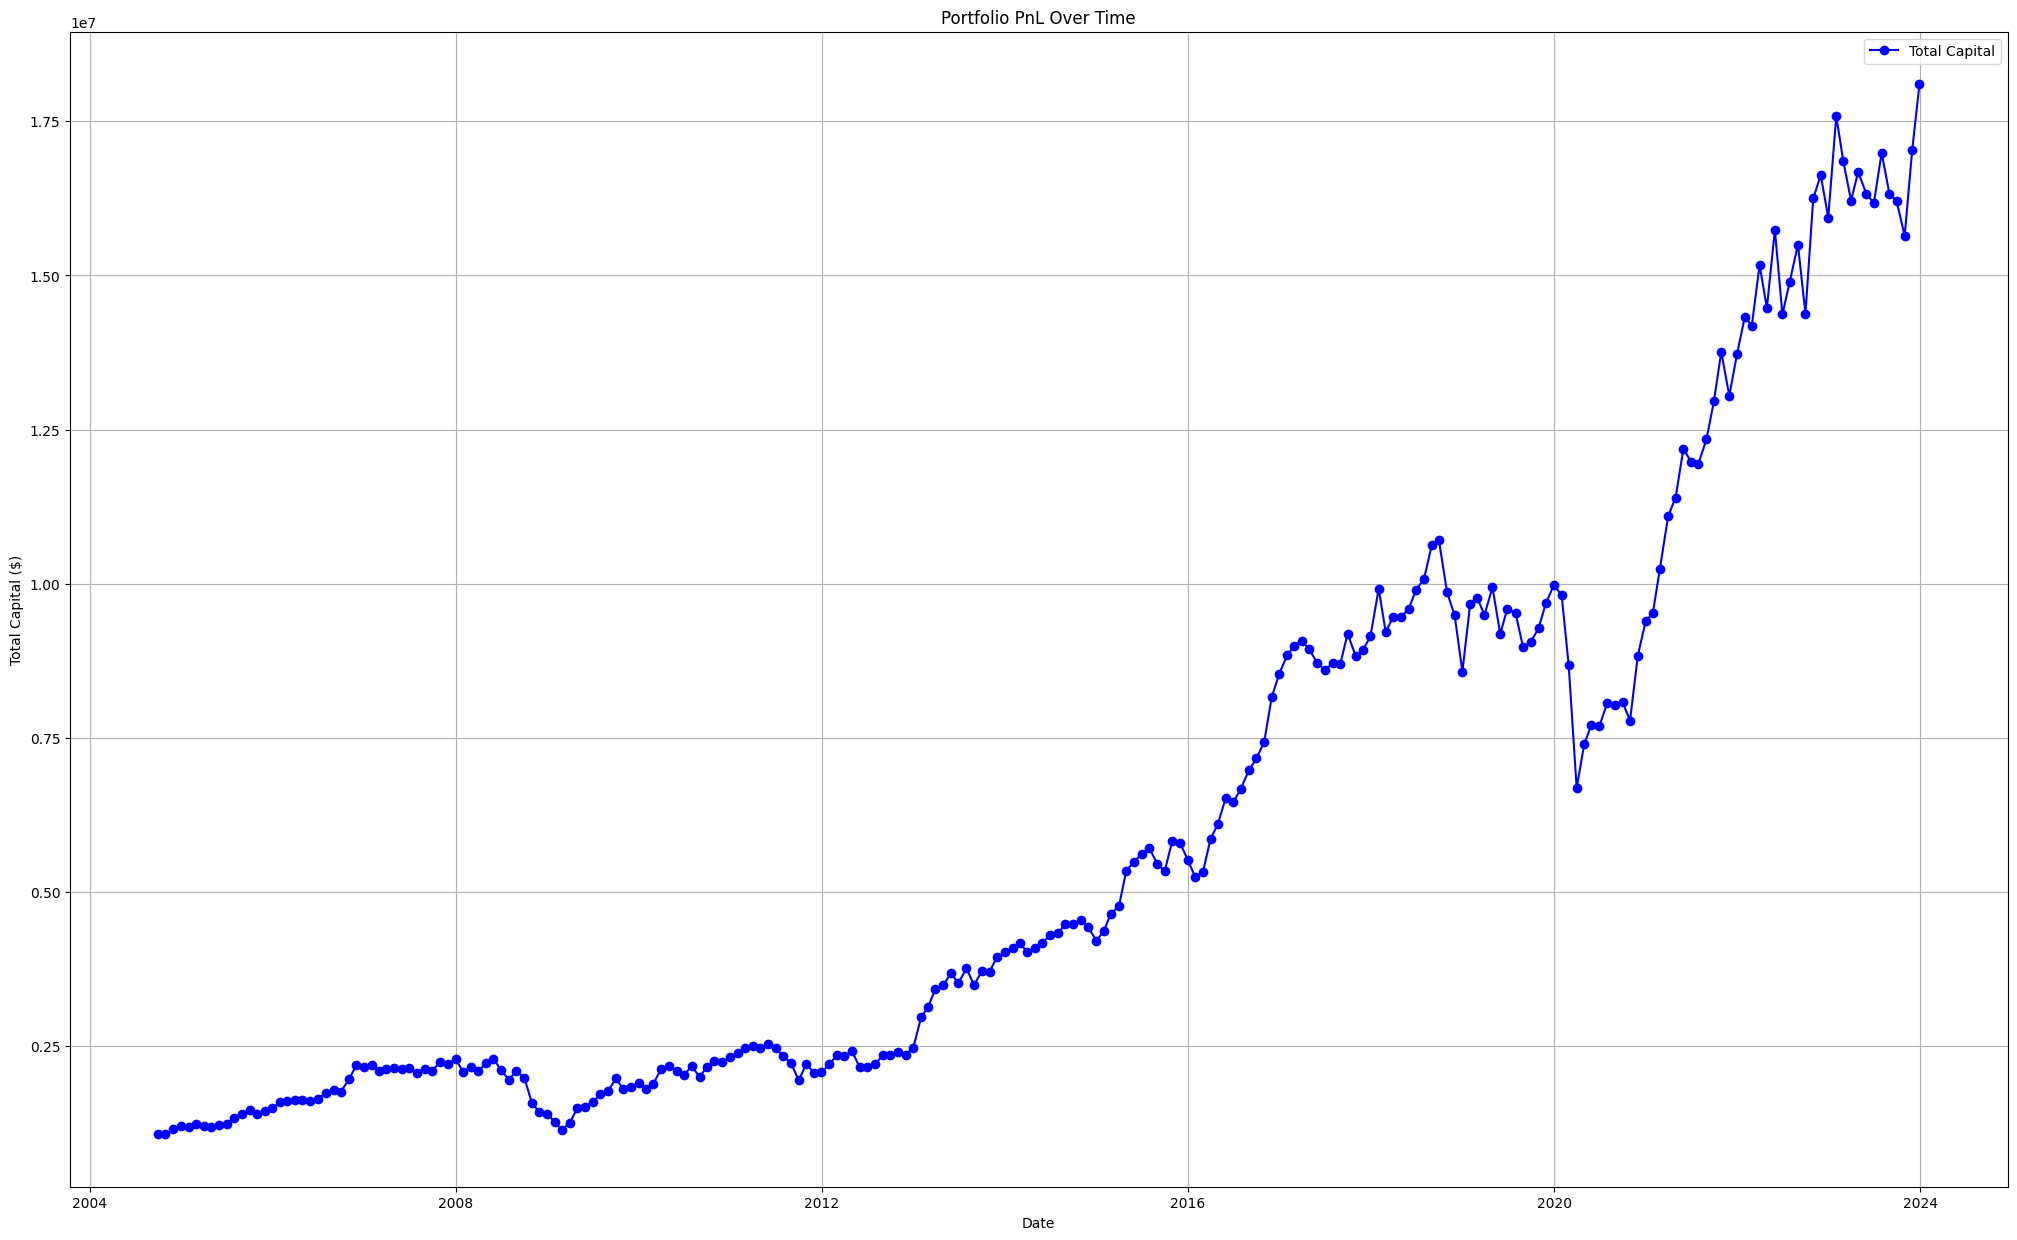

In [136]:
initial_capital = 1_000_000
cumulative_pnl = initial_capital * np.cumprod(1 + portfolio_returns)
# Ensure the lengths of dates and cumulative_pnl match
if len(dates[window:]) != len(cumulative_pnl):
    min_length = min(len(dates[window:]), len(cumulative_pnl))
    dates = dates[window:][:min_length]
    cumulative_pnl = cumulative_pnl[:min_length]

# Now plot
plt.figure(figsize=(25, 15))
plt.plot(dates[window:], cumulative_pnl, marker='o', linestyle='-', color='b', label="Total Capital")
plt.xlabel("Date")
plt.ylabel("Total Capital ($)")
plt.title("Portfolio PnL Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [131]:
results_df.to_csv("/content/results.csv")